### Brute Force Simulation of 1d transverse field Ising model.


The 1d transverse field Ising model features a chain of spins (qubits) with a
magnetic field orthogonal to the chain. The qubits only interact with the nearest
neighbours.
The Hamiltonian is of the form:

\begin{equation}
H = J \sum_{i=1}^{N-1} \sigma_i^z \sigma_{i+1}^z + h \sum_{i=1}^{N} \sigma_i^x
\end{equation}

for open boundary conditions (first and last lattice site only have one neighbour).
The $\sigma_i$ are Pauli matrices, N is the number of qubits and $J$ and $h$ are coupling
constants describing the coupling strength of the
nearest neighbour interaction and the strength of the magnetic field respectively.
If we assume periodic boundary conditions the last qubit interacts with the first qubit.
The Hamiltonian takes the form:

\begin{equation}
H = J \sum_{i=1}^{N} \sigma_i^z \sigma_{i+1}^z + h \sum_{i=1}^{N} \sigma_i^x
\end{equation}

where we assume $\sigma^z_{N+1} = \sigma^z_1$.

We simulate the 1d transverse field Ising model for different numbers of qubits (Spins) $N$
and for different ratios $\frac{h}{J}$. We consider both the ferromagnetic case ($J = -1$) and
 the antiferromagnetic case ($J=1$). In the
following we calculate the numerical values for the oberservables energy-gap,
two-point-correlation, correlation length and entanglement entropy.
To calculate all of these we need the ground state and the first three eigenvalues of our
Hamiltonians. Thus, we calculate them first and store them because this is the most
computationally expensive part.

In [1]:
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import sys
from pathlib import Path
sys.path.append(Path('../src'))
from tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from bf_quantum_state import BFQuantumState

In [2]:
#global variables
ratios_h_j = np.array([0.01, 0.02, 0.05, 0.1,
                           0.2, 0.5, 1, 2, 5, 10, 20, 50, 100], dtype=float)
save_direc_eigs = Path('data/Diagonal_hamiltonian/eigenvalues_first_three_dict.npy')
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')

In [3]:
# calculate for open and periodic boundary conditions ferromagnetic and antiferromagnetic case

qubit_numbers = np.array([8, 12])
#creating nested dictionaries
energy_eig_vals_dict = {}
ground_state_dict = {}
for k in range(0, 2):
    if k == 0:
        J_val = 1 #antiferromagnetic case
    else:
        J_val = -1 #ferromagnetic case
    energy_eig_vals_dict[str(J_val)] = {}
    ground_state_dict[str(J_val)] = {}
    for l in range(0,2):
        if l==0:
            boundary = 'periodic'
        else:
            boundary = 'open'
        energy_eig_vals_dict[str(J_val)][boundary] = {}
        ground_state_dict[str(J_val)][boundary] = {}
        for i in range(0, np.size(qubit_numbers)):
            energy_eig_vals_dict[str(J_val)][boundary][str(qubit_numbers[i])] = {}
            ground_state_dict[str(J_val)][boundary][str(qubit_numbers[i])] = {}
            for j in range(0, np.size(ratios_h_j)):
                energy_eig_vals, eigvecs = TfimHamiltonianOpenFermion(qubit_numbers[i], ratios_h_j[j], J_val, boundary).diagonalize(3, True)
                ground_state = pt.tensor(eigvecs[:, 0])
                energy_eig_vals_dict[str(J_val)][boundary][str(qubit_numbers[i])][str(ratios_h_j[j])] = energy_eig_vals
                ground_state_dict[str(J_val)][boundary][str(qubit_numbers[i])][str(ratios_h_j[j])] = ground_state
np.save(save_direc_eigs, energy_eig_vals_dict)
np.save(save_direc_groundstate, ground_state_dict)

### ground state energy per qubit
We would like to calculate the energy $E_0$ of the ground state divided by the number of
qubits $N$. We do this for both periodic and open boundary conditions and for
the ferromagnetic and antiferromagnetic case.
 We then compare the periodic case with the value predicted by theory for periodic boundary
conditions. The ground state energy is given by

\begin{equation}
E_0 = - \sum_{k>0} \epsilon_k
\end{equation} (periodic boundary conditions)

where

\begin{equation}
\epsilon_k = 2J \sqrt{(\cos{k} - |\frac{h}{J}|)^2 + \sin^2{k}}
\end{equation}.

$k$ can take the values:

\begin{equation}
k \in \left(\frac{(2n-1)\pi}{N};   n=1, ..., N/2 \right)
\end{equation}

$N$ is the number of qubits.

We start with plotting the ground state energy for periodic boundary conditions
 using our exact simulation for the example of 12 and 14 qubits.

[  -1.000025     -1.0001       -1.0006251    -1.00250157   -1.01002525
   -1.06354743   -1.27688293   -2.12709486   -5.05012627  -10.02501566
  -20.01250195  -50.00500013 -100.00250002]
[  -1.000025     -1.0001       -1.0006251    -1.00250157   -1.01002525
   -1.063545     -1.2759149    -2.12709001   -5.05012627  -10.02501566
  -20.01250195  -50.00500013 -100.00250002]
[  -0.91669583   -0.91678334   -0.91739596   -0.91958542   -0.92836705
   -0.99097322   -1.24383093   -2.11612473   -5.04592782  -10.02292841
  -20.0114598   -50.00458343 -100.00229168]
[  -0.9286       -0.92868572   -0.92928584   -0.93143059   -0.94003251
   -1.00135035   -1.24792886   -2.11769103   -5.0465276   -10.02322659
  -20.01160868  -50.00464296 -100.00232144]
[  -1.000025     -1.0001       -1.0006251    -1.00250157   -1.01002525
   -1.06354743   -1.27688293   -2.12709486   -5.05012627  -10.02501566
  -20.01250195  -50.00500013 -100.00250002]
[  -1.000025     -1.0001       -1.0006251    -1.00250157   -1.01002525

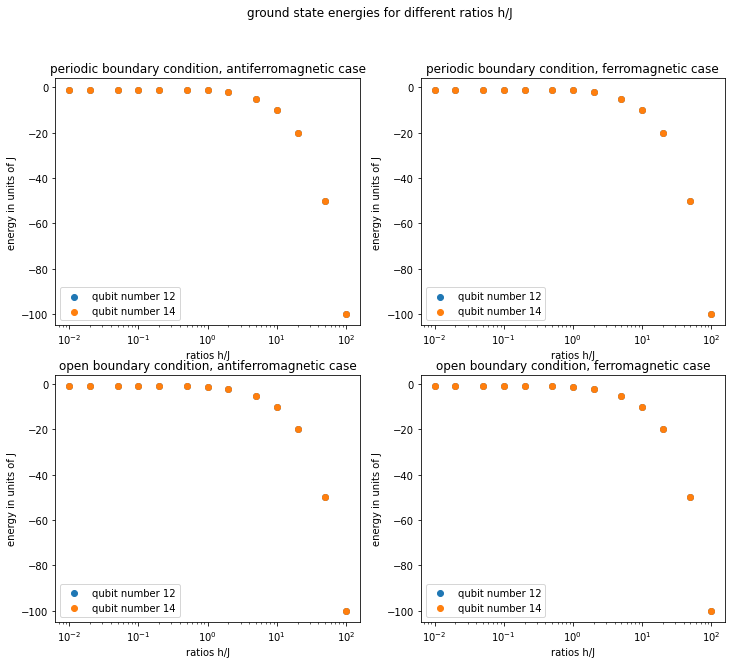

In [9]:
qubit_num = np.array([12, 14])
energy_dict = np.load(save_direc_eigs, allow_pickle='TRUE')
energy_dict = energy_dict.item()
fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.suptitle('ground state energies for different ratios h/J')
for k in range(0, 2):
    if k == 0:
        J_val = 1 #antiferromagnetic case
        magnetisation = 'antiferromagnetic'
    else:
        J_val = -1 #ferromagnetic case
        magnetisation = 'ferromagnetic'
    for l in range(0,2):
        if l==0:
            boundary = 'periodic'
        else:
            boundary = 'open'
        for i in range(0, np.size(qubit_num)):
            energy = np.zeros(np.size(ratios_h_j))
            for j in range(0, np.size(ratios_h_j)):
                energy[j] = energy_dict[str(J_val)][boundary][str(qubit_num[i])][str(ratios_h_j[j])][0]
            energy_per_qubit = energy / qubit_num[i]
            axs[l, k].scatter(ratios_h_j, energy_per_qubit, label='qubit number ' + str(qubit_num[i]))
        axs[l, k].set(xscale='log', xlabel='ratios h/J',
                      ylabel='energy in units of J')
        axs[l, k].set_title(boundary + ' boundary condition, ' + magnetisation + ' case')
        axs[l, k].legend()
plot_save_direc = 'plots\Ground_state_energy\Ground_state_energies_per_qubit'
plt.savefig(plot_save_direc)


Now we compare the periodic case with the theoretical prediction and plot the difference
$E_{simulated} - E_{theo}$.


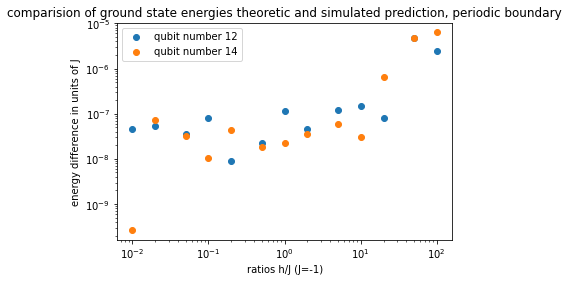

In [15]:
qubit_num = np.array([12, 14])
energy_dict = np.load(save_direc_eigs, allow_pickle='TRUE')
energy_dict = energy_dict.item()
for i in range(0, np.size(qubit_num)):
    energy_sim = np.zeros(np.size(ratios_h_j))
    energy_theo = np.zeros(np.size(ratios_h_j))
    for j in range(0, np.size(ratios_h_j)):
        energy_sim[j] = energy_dict[str(1)]['periodic'][str(qubit_num[i])][str(ratios_h_j[j])][0]
        energy_theo[j] = TfimHamiltonianOpenFermion(qubit_num[i], ratios_h_j[j], 1, 'periodic').ground_state_energy_theo()
    energy_diff_per_qubit = np.abs(np.abs(energy_sim) - np.abs(energy_theo)) / qubit_num[i]
    plt.scatter(ratios_h_j, energy_diff_per_qubit, label='qubit number ' + str(qubit_num[i]))
plt.yscale('log')
plt.xscale('log')
plt.title('comparision of ground state energies theoretic and simulated prediction, periodic boundary')
plt.xlabel('ratios h/J (J=-1)')
plt.ylabel('energy difference in units of J')
plt.legend()
plot_save_direc = 'plots\Ground_state_energy\comparison_theo_and_simulated'
plt.savefig(plot_save_direc)



This shows that the theoretical and our simulated model agree in their precdictions since
all deviations are very small and due to random numerical rounding issues.


### Energy gap estimation
We would like to calculate the energy gap $E_{gap}$ between the ground state energy
 $E_{ground}$ and the
first excited state $E_{excited}$.

For the case $J>h$ the coupling between the qubits is
the dominant interaction and not the outer magnetic field. Thus, in the ferromagnetic
 case ($J<0$) when measuring in the
z-basis the spins are all aligned in one direction since this is the lowest energy state. The two configurations where all
spins are pointing and where all spins are pointing down are equivalent. Thus, the ground
state is two-fold-degenerate and the first two energy eigenvalues are the same. Therefore,
the energy gap is given by $E_{gap} = E_2 - E_0$ where $E_0$ is the 0-th energy eigenvalue and
$E_2$ is the second. This is similar for the antiferromagnetic case where all neighbouring spins
are anti-aligned. There are two equivalent configurations with one half of the spins pointing
either up or down and the other half being in the anti-parallel configuration.

$J = h$ is the point of the phase transition where the degenerate state starts to
split up. The energy gap is still given by $E_{gap} = E_2 - E_0$.


For the case $J < h $ the magnetic field is dominant and the ground state is not
two-fold-degenerate anymore. Hence, the energy gap is given by $E_{gap} = E_1 - E_0$.

In our simulation we obtain the energy gap by exactly diagonalizing the Hamiltonian
from which we get the energy eigenvalues.


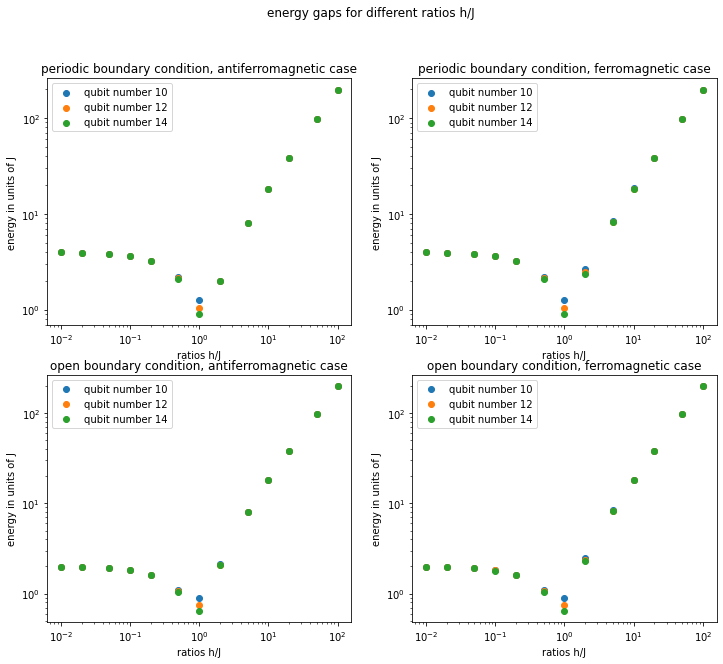

In [7]:
qubit_numbers = ([10, 12, 14])
energies_dict = np.load(save_direc_eigs, allow_pickle='TRUE')
energies_dict = energies_dict.item()
fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.suptitle('energy gaps for different ratios h/J')
for k in range(0, 2):
    if k == 0:
        J_val = 1 #antiferromagnetic case
        magnetisation = 'antiferromagnetic'
    else:
        J_val = -1 #ferromagnetic case
        magnetisation = 'ferromagnetic'
    for l in range(0,2):
        if l==0:
            boundary = 'periodic'
        else:
            boundary = 'open'
        for i in range(0, np.size(qubit_numbers)):
            energy_gaps = np.zeros(np.size(ratios_h_j))
            for j in range(0, np.size(ratios_h_j)):
                energy_gaps[j] = TfimHamiltonianOpenFermion(qubit_numbers[i],
                                                            ratios_h_j[j], J_val, boundary).energygap(energies_dict[str(J_val)][boundary][str(qubit_numbers[i])][str(ratios_h_j[j])])
            axs[l, k].scatter(ratios_h_j, energy_gaps, label='qubit number ' + str(qubit_numbers[i]))
        axs[l, k].set(xscale='log', yscale = 'log', xlabel='ratios h/J',
                      ylabel='energy in units of J')
        axs[l, k].set_title(boundary + ' boundary condition, ' + magnetisation + ' case')
        axs[l, k].legend()
plot_save_direc = 'plots\energy_gap_brute_force\energy_gaps'
plt.savefig(plot_save_direc)

We can see small differences between the cases. In this diagram we can see them especially at
$\frac{h}{J}=1$ and $\frac{h}{J}=2$ because there we can compare the position of the dots
for the different qubit numbers. For the other values of $\frac{h}{J}$ we cannot see
the deviations right away from these diagrams.

Now we would like to compare the energy gaps we calculated by exact diagonalization
with those predicted by theory.

As described in the paper 'The quantum ising chain for beginners'
the Ising Hamiltonian can be mapped to a fermionic Hamiltonian
using the Jordan-Wigner-Transformation of the spin operators.
When considering periodic boundary conditions this gives us two
different cases how the fermionic operators $\hat{c}_1$
 and $\hat{c}_{N+1}$ can be related.

\begin{equation}
\hat{c}_{N+1} = (-1)^{p+1}\hat{c}_1
\end{equation}

Where $p \in \{ 0,1\}$ is the overall parity of the fermions,
$p=0$ for even and $p=1$ for odd parity.
Thus, there is an even and an odd particle subsector of
our fermionic Hamiltonian. For each subsector there is a ground state.
In the $p=0$ (antiperiodic boundary condition ABC) subsector
the ground state energy is given by:

\begin{equation}
E_0^{ABC} = - \sum_{k>0} \epsilon_k
\end{equation}

where

\begin{equation}
\epsilon_k = 2J \sqrt{(\cos{k} - |\frac{h}{J}|)^2 + \sin^2{k}}
\end{equation}.

$k$ can take the values:

\begin{equation}
k \in \left(\frac{(2n-1)\pi}{N};   n=1, ..., N/2 \right)
\end{equation}

$N$ is the number of qubits.

The ground state energy in the $p=1$ (periodic boundary condition PBC)
subsector is given by:

\begin{equation}
E_0^{PBC} = -2J - \sum_{0<k<\pi}^{PBC} \epsilon_k
\end{equation}

where the $\epsilon_k$ are the same as before but $k$ now takes the values:
\begin{equation}
k \in \left(\frac{2n\pi}{N};   n=1, ..., N/2 - 1 \right)
\end{equation}

It turns out that the actual global ground state is $E_0^{ABC}$.

All excited states in the $p=0$ (ABC) sector are given by:

\begin{equation}
E_{n_k} = E_0^{ABC} + \sum_k n_k \epsilon_k
\end{equation}

where $E_0^{ABC}$ is the ground state.
The $n_k \in {0,1}$ are the occupation numbers
where $\sum_k n_k $ has to be even.
The $\epsilon_k$ are the same as before.

The lowest energy in the $p=1$ (PBC) sector is given by the expression for
$E_0^{PBC}$ above. Whether an excited state from the ABC sector or
the ground state from the PBC is the first excited global state
has to be determined. We calculate both and then choose the lower one.

As discussed above for $h <= J$ the ground state is twofold degenerate
which is why we choose the gap to be $E_{gap} = E_2 - E_0$ where $E_0$ is the 0-th
energy eigenvalue and $E_2$ is the second. For $h > J$ we choose $E_{gap} = E_1 - E_0$.

We compare the theoretical prediction with the simulated
 case for the antiferromagnetic (J = 1), periodic case
by plotting the difference.

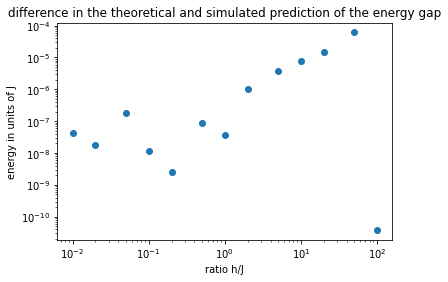

In [10]:
qubit_num = 14
energy_gaps_theo = np.zeros(np.size(ratios_h_j))
energy_gaps_simulated = np.zeros(np.size(ratios_h_j))
energies_dict = np.load(save_direc_eigs, allow_pickle='TRUE')
energies_dict = energies_dict.item()

for i in range(0, np.size(ratios_h_j)):
    energy_gaps_theo[i] = float(TfimHamiltonianOpenFermion(14, ratios_h_j[i],
                                                1, 'periodic').theo_energygap_finite_size())
    energy_gaps_simulated[i] = float(TfimHamiltonianOpenFermion(qubit_num, ratios_h_j[i], 1, 'periodic').energygap(energies_dict[str(1)]['periodic'][str(qubit_num)][str(ratios_h_j[i])]))
    difference = np.abs(energy_gaps_simulated - energy_gaps_theo)

plt.xscale('log')
plt.yscale('log')
plt.title('difference in the theoretical and simulated prediction of the energy gap')
plt.ylabel('energy in units of J')
plt.xlabel('ratio h/J')
plt.scatter(ratios_h_j, difference)

From this we can see that the theoretical prediction agrees very well with our simulated
values since all deviations are very small and stem from numerical rounding issues.

### Two point correlation of the ground state $\Psi_0$
The two point correlation between two qubits in the ground state $\Psi_0$
 measured in the z-basis is defined by
$\langle \Psi_0 | \sigma_0^z \sigma_i^z |\Psi_0 \rangle$. We calculate the two point
correlations for different distances $i$ and investigate how the correlation decays for
different ratios $\frac{h}{J}$.
In this example we plot the two point correlation for 14 qubits and for different ratios of
$\frac{h}{J}$.


In [3]:
def plot_two_point_correlation_log(basis: str):
    qubit_num = 14
    ratios = np.array([0.2, 1, 5])
    ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
    ground_state_dict = ground_state_dict.item()
    fig, axs = plt.subplots(2,2)
    fig.set_figheight(10)
    fig.set_figwidth(17)
    fig.suptitle('two point correlation for different ratios, boundary conditios and magnetisations')
    for k in range(0, 2):
        if k == 0:
            J_val = 1 #antiferromagnetic case
            magnetisation = 'antiferromagnetic'
        else:
            J_val = -1 #ferromagnetic case
            magnetisation = 'ferromagnetic'
        for l in range(0,2):
            if l==0:
                boundary = 'periodic'
            else:
                boundary = 'open'
            for i in range(0, np.size(ratios)):
                distance = np.arange(0, qubit_num, 1)
                correlations = np.zeros(qubit_num)
                ground_state = ground_state_dict[str(J_val)][boundary][str(qubit_num)][str(ratios[i])]
                for j in range(0, qubit_num):
                    correlations[j] = BFQuantumState(qubit_num, ground_state).two_point_correlation(distance[j], basis)
                axs[l,k].scatter(distance, np.abs(correlations), label='ratio h/J = ' + str(ratios[i]))
            axs[l, k].set(yscale = 'log', xlabel='distance, j-th neighbour',
                          ylabel='two_point_correlation')
            axs[l, k].set_title(boundary + ' boundary condition, ' + magnetisation + ' case')
            axs[l, k].legend()



    plot_save_direc = 'plots\Two_point_correlation_brute_force\correlation_for_ratio ' + str(ratios).replace('.',
                                                                                                             ',') + ' and qubit number ' + str(qubit_num) + ' basis ' + basis
    plt.savefig(plot_save_direc)

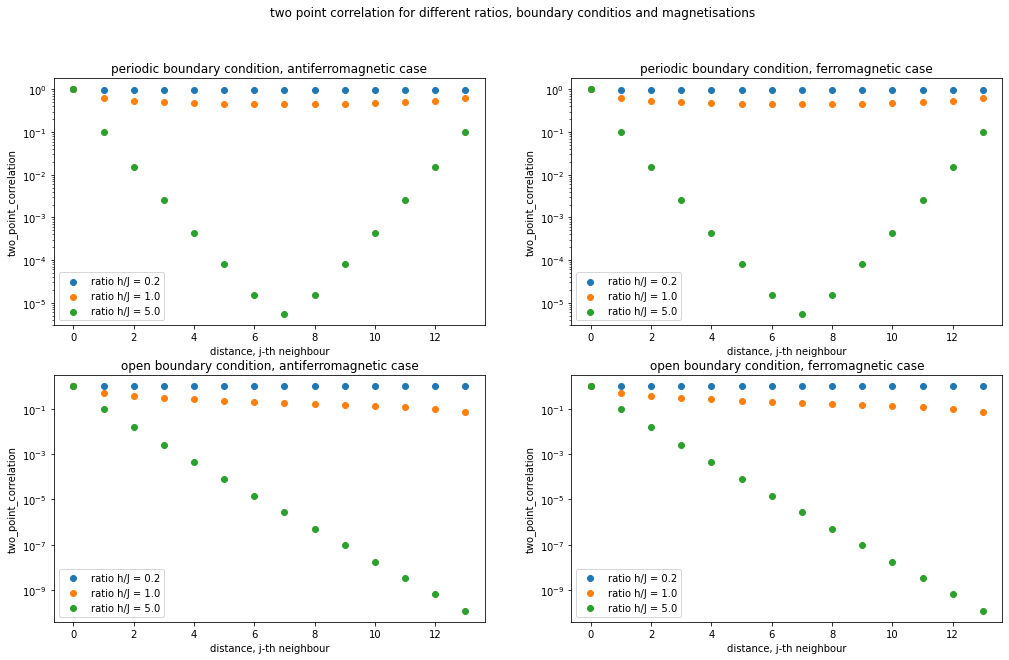

In [4]:
plot_two_point_correlation_log('Z')


Ferromagentic case, open boundary conditions:

From this we can see that for $\frac{h}{J} > 1$ the correlation decays exponentially
while it decays polynomially for $\frac{h}{J} <= 1$. The reason for this is that for
$\frac{h}{J} < 1$ all spins are either pointing up or down as already discussed. Thus, the
system is mostly in the state $\Psi_0 = \frac{e^{i \phi}}{\sqrt{2}} |00 ... 0 \rangle \pm |11 ... 1 \rangle$.
Therefore, we know the state of qubit $i$ with almost perfect certainty when we learn
about the state of qubit $0$ in the z-basis.

For $\frac{h}{J} > 1$ the qubits start to align with the magnetic field and converge
towards the state $\Psi_0 = e^{i \phi} |++ ... + \rangle$ where $|+ \rangle = \frac{1}{\sqrt{2}}
|0 \rangle + |1 \rangle$. Thus, when measuring the correlation in the z-basis the
system converges towards a perfectly uncorrelated state for $h \rightarrow \infty $.

For $\frac{h}{J} = 1$ we are still mostly in the perfectly correlated state
$\Psi_0 = \frac{e^{i \phi}}{\sqrt{2}} |00 ... 0 \rangle \pm |11 ... 1 \rangle$ and hence
the correlation decays slower than exponentially.

For the antiferromagnetic case the explanation is almost the same except that we
have to replace $\Psi_0 = \frac{e^{i \phi}}{\sqrt{2}} |00 ... 0 \rangle \pm |11 ... 1 \rangle$
with $\Psi_0 = \frac{e^{i \phi}}{\sqrt{2}} |01010... 1 \rangle \pm |10101 ... 0 \rangle$
(anti-correlated neighbouring spins for $\frac{h}{J} < 1$).

For periodic boundary conditions the correlation of course starts to grow again after
reaching the middle because the distance between the qubits effectively starts
shrinking again because of the periodic boundary conditions. This is also why
the graph is symmetric around the distance to the qubit in the middle.

We plot the two-point correlation again but this time without the log scale and without
taking the absolute value (negative values allowed).


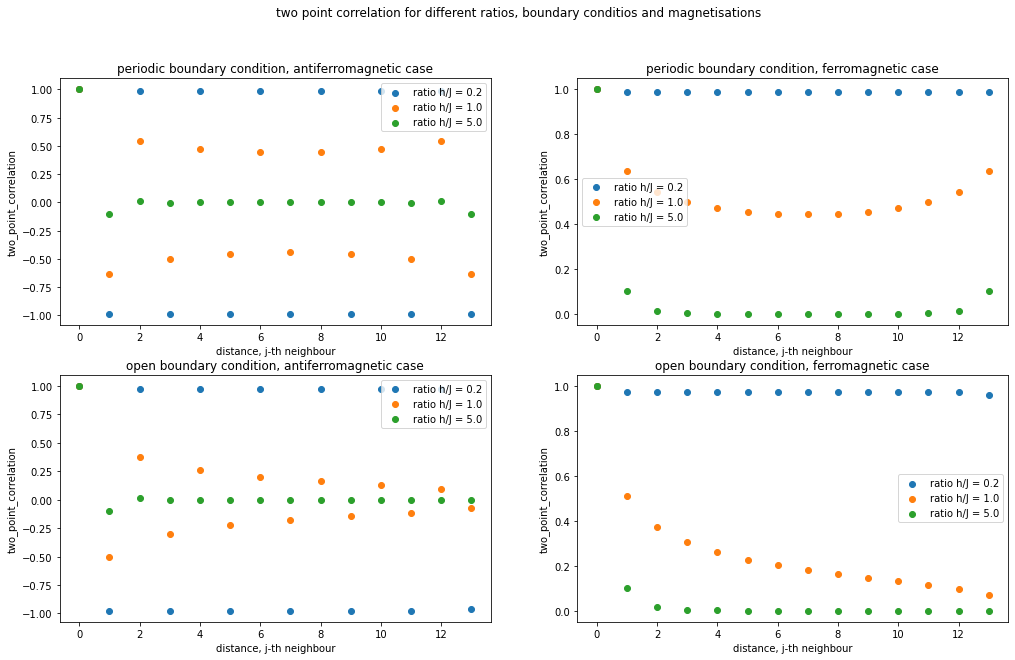

In [5]:
qubit_num = 14
ratios = np.array([0.2, 1, 5])
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()
fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(17)
fig.suptitle('two point correlation for different ratios, boundary conditios and magnetisations')
for k in range(0, 2):
    if k == 0:
        J_val = 1 #antiferromagnetic case
        magnetisation = 'antiferromagnetic'
    else:
        J_val = -1 #ferromagnetic case
        magnetisation = 'ferromagnetic'
    for l in range(0,2):
        if l==0:
            boundary = 'periodic'
        else:
            boundary = 'open'
        for i in range(0, np.size(ratios)):
            distance = np.arange(0, qubit_num, 1)
            correlations = np.zeros(qubit_num)
            ground_state = ground_state_dict[str(J_val)][boundary][str(qubit_num)][str(ratios[i])]
            for j in range(0, qubit_num):
                correlations[j] = BFQuantumState(qubit_num, ground_state).two_point_correlation(distance[j], 'Z')
            axs[l,k].scatter(distance, correlations, label='ratio h/J = ' + str(ratios[i]))
        axs[l, k].set(xlabel='distance, j-th neighbour',
                      ylabel='two_point_correlation')
        axs[l, k].set_title(boundary + ' boundary condition, ' + magnetisation + ' case')
        axs[l, k].legend()



plot_save_direc = 'plots\Two_point_correlation_brute_force\correlation_for_ratio ' + str(ratios).replace('.',
                                                                                                         ',') + ' and qubit number ' + str(qubit_num) + ' no log scale'
plt.savefig(plot_save_direc)


Now we can see an oscillating pattern for the antiferromagnetic case. This is explained
by the fact that neighbouring spins are anti-parallel and therefore perfectly
anti-correlated for a strong coupling constant $J$.

Now we would like to measure the two-point-correlation in every basis instead of only
in the z-basis. We replace the correlation function $\langle \Psi_0 | \sigma_0^z \sigma_i^z |\Psi_0 \rangle$
by $\langle \Psi_0 | \vec{\sigma_0} \vec{\sigma_i} |\Psi_0 \rangle$ where
 $\vec{\sigma}$ is the vector of pauli matrices.


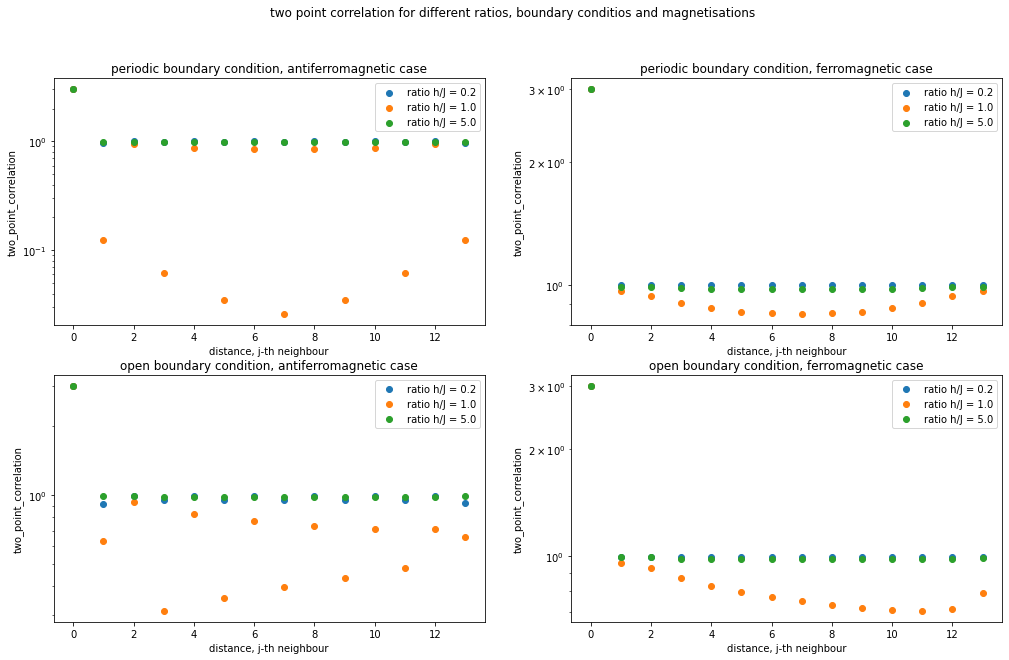

In [6]:
plot_two_point_correlation_log('XYZ')

We should dicuss whether plotting this really makes sense.
Moreover, I plot the two point correlation measured in the x basis and in the y basis
$\langle \Psi_0 | \sigma_0^x \sigma_i^x |\Psi_0 \rangle$ /
$\langle \Psi_0 | \sigma_0^y \sigma_i^y |\Psi_0 \rangle$.


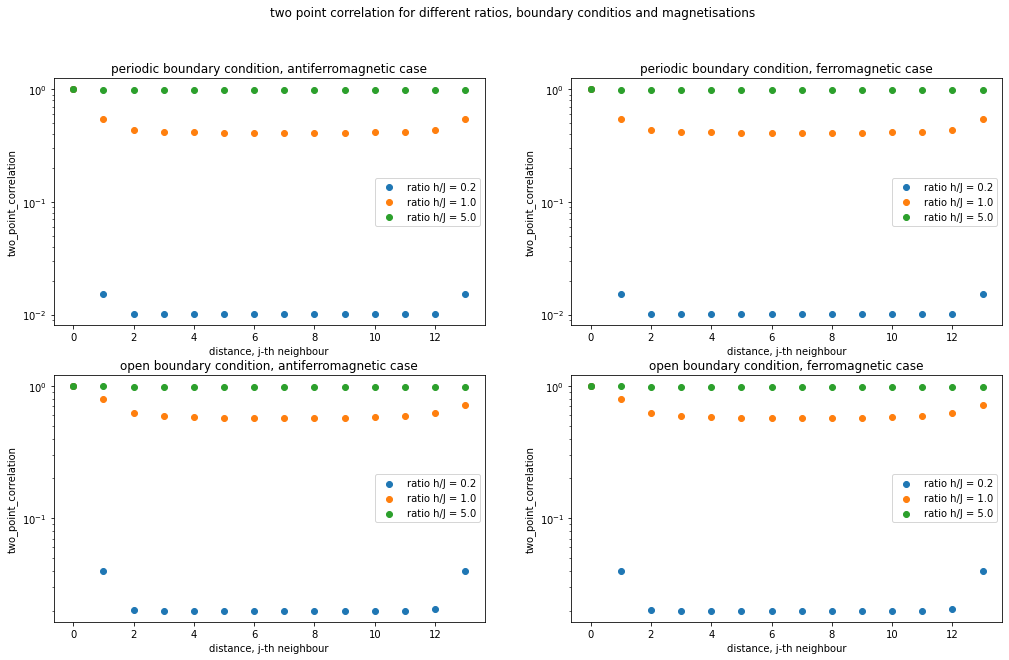

In [7]:
plot_two_point_correlation_log('X')


Since the outer magnetic field is a global phenomenon the correlation does not depend
much on the distance but mostly on the coupling constant $h$. For a strong magnetic
field they are highly correlated.

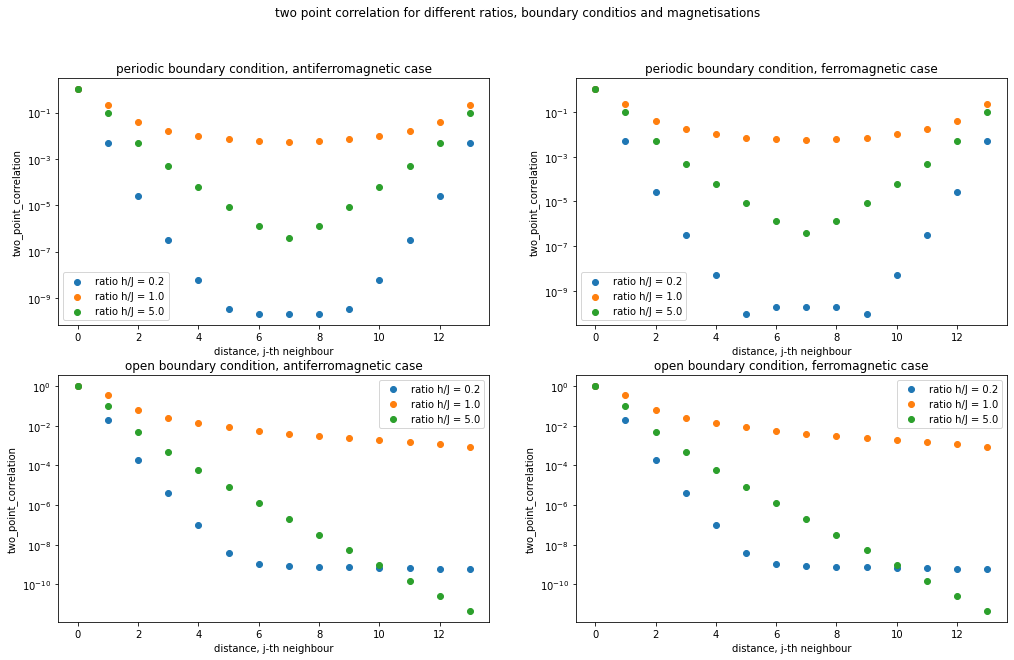

In [8]:
plot_two_point_correlation_log('Y')

### Correlation length
Now we would like to see after which distance the correlation
$\langle \Psi_0 | \sigma_0^z \sigma_i^z |\Psi_0 \rangle$ has decayed by
$\frac{1}{e}$. We call this distance the correlation length.

In [3]:
def plot_correlation_length(basis):
    qubit_num = np.array([10, 12, 14])
    ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
    ground_state_dict = ground_state_dict.item()
    fig, axs = plt.subplots(2,2)
    fig.set_figheight(10)
    fig.set_figwidth(12)
    fig.suptitle('two point correlation for different ratios, boundary conditions and magnetisation types')
    for k in range(0, 2):
        if k == 0:
            J_val = 1 #antiferromagnetic case
            magnetisation = 'antiferromagnetic'
        else:
            J_val = -1 #ferromagnetic case
            magnetisation = 'ferromagnetic'
        for l in range(0,2):
            if l==0:
                boundary = 'periodic'
            else:
                boundary = 'open'
            something_not_nan = False
            for i in range(0, np.size(qubit_num)):
                correlation_length = np.zeros(np.size(ratios_h_j))
                for j in range(0, np.size(ratios_h_j)):
                    ground_state = ground_state_dict[str(J_val)][boundary][str(qubit_num[i])][str(ratios_h_j[j])]
                    correlation_length[j] = BFQuantumState(qubit_num[i], ground_state).correlation_length(basis)
                    if not np.isnan(correlation_length[j]):
                        something_not_nan = True
                if something_not_nan:
                    axs[l, k].scatter(ratios_h_j, np.abs(correlation_length), label='qubit number = ' + str(qubit_num[i]))
                    axs[l, k].set(xscale = 'log', xlabel='ratios h/J',
                          ylabel='correlation length')
                    axs[l, k].set_title(boundary + ' boundary condition, ' + magnetisation + ' case')
                    axs[l, k].legend()
                else:
                    print('for ' + boundary + ' boundary condition and ' + magnetisation + ' magnetisation the value 1/e is never reached for any ratio h/J')

    plot_save_direc = 'plots\Correlation_length\correlation_lengths_for_qubit_numbers ' + str(qubit_num) + ' basis' + basis
    plt.savefig(plot_save_direc)


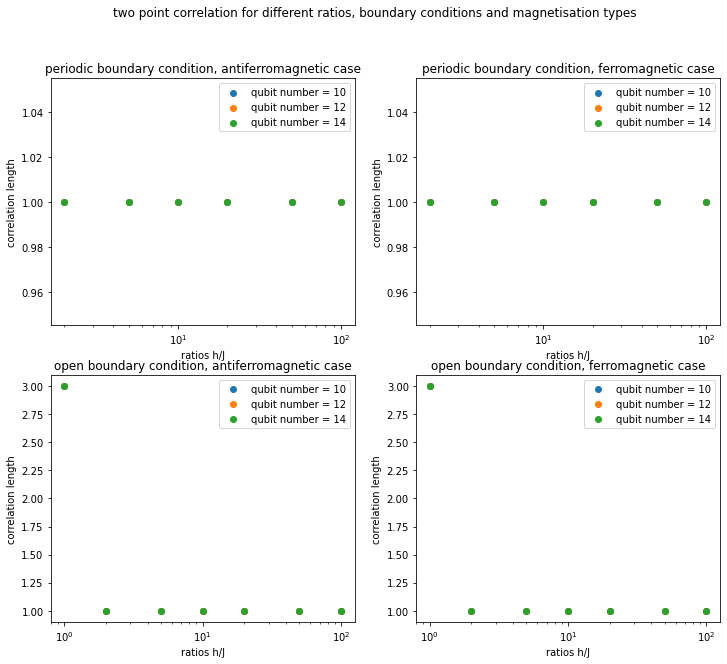

In [4]:
plot_correlation_length('Z')

Values for which the correlation does not decay to $\frac{1}{e}$ are not displayed at all
We can see that only for $\frac{h}{J} >= 1$ the correlation decays fast enough to
reach $\frac{1}{e}$ (open boundary conditions). For periodic boundary
conditions it only reaches $\frac{1}{e}$ if $\frac{h}{J} > 1$.
 It might be interesting to investigate the region around $\frac{h}{J} = 1$
closer or to increase the decay threshold $\frac{1}{e}$ to see more
clearly how the correlation length decays.

We also plot the correlation length for the correlation measured in every basis. This is
given by the correlation function
$\langle \Psi_0 | \vec{\sigma_0} \vec{\sigma_i} |\Psi_0 \rangle$ where
 $\vec{\sigma}$ is the vector of pauli matrices.


for periodic boundary condition and ferromagnetic magnetisation the value 1/e is never reached for any ratio h/J
for periodic boundary condition and ferromagnetic magnetisation the value 1/e is never reached for any ratio h/J
for periodic boundary condition and ferromagnetic magnetisation the value 1/e is never reached for any ratio h/J
for open boundary condition and ferromagnetic magnetisation the value 1/e is never reached for any ratio h/J
for open boundary condition and ferromagnetic magnetisation the value 1/e is never reached for any ratio h/J
for open boundary condition and ferromagnetic magnetisation the value 1/e is never reached for any ratio h/J


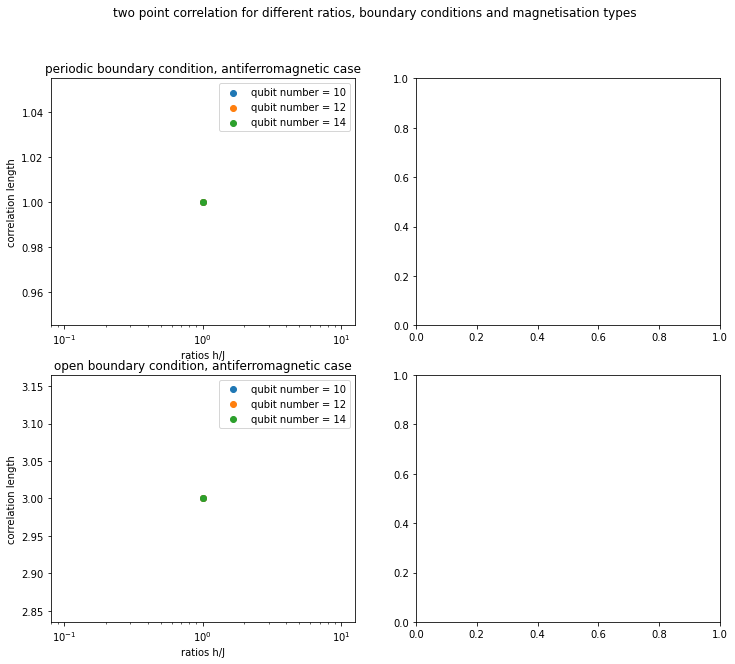

In [5]:
plot_correlation_length('XYZ')

### Entanglement entropy
The entanglement entropy is defined as S = $- Tr (\rho_A \log \rho_A)$ where $\rho_A = Tr_B \rho_{AB}$.
Subsystem A contains the first $\frac{N}{2}$ qubits and subsystem B the last $\frac{N}{2}$ qubits.
We showed that when the state $|\Psi \rangle$ has the Schmidt decomposition
$|\Psi \rangle = \sum_j \lambda_j |j_A \rangle | j_B \rangle$ then the entanglement
entropy is given by $S = - \sum_j \lambda_j^2 \log{\lambda_j^2}$.

We can write $| \Psi \rangle$ as $| \Psi \rangle = \sum_{j,k} M_{jk} |j \rangle
|k \rangle $  where the $|j \rangle$ are a basis for system A and the $|k \rangle $
 a basis for system B. Thus the $\lambda_j$ are the singular values of the matrix
 $M_{jk}$ which is just $|\Psi \rangle$ in matrix form ($M_{jk}$ is a $2^{N-1} \times 2^{N-1}$
 matrix with the first $2^{N-1}$ values of $|\Psi \rangle$ in the first row and
 the next $2^{N-1}$ values of $|\Psi \rangle$ in the next row and so on).
 Thus, we can compute the entanglement entropy by computing the singular values of the
 matrix $M$.

 We calculate the entanglement entropy for different ratios of $\frac{h}{j}$ and qubit
 numbers N in the ground state $\Psi_0$. We consider open and periodic boundary conditions
 and the ferromagnetic and antiferromagnetic case.

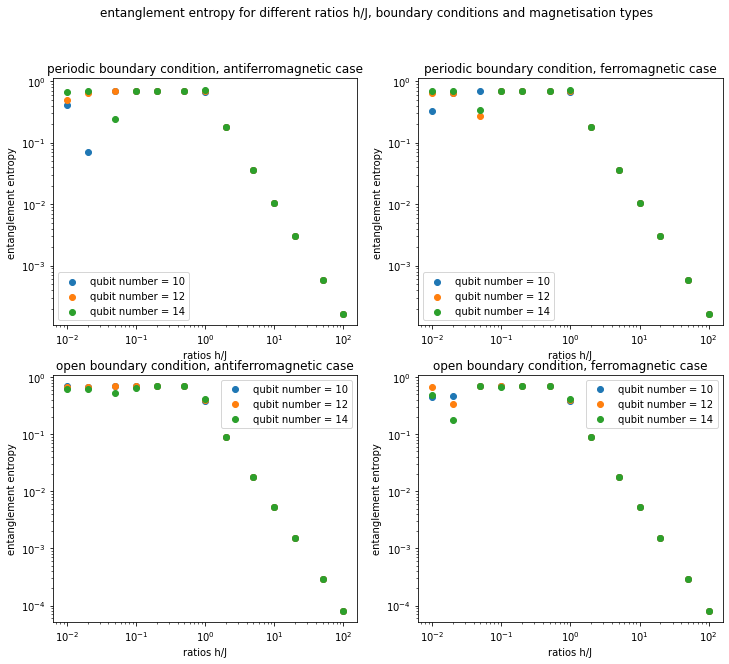

In [15]:

qubit_num = np.array([10, 12, 14])
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()
fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.suptitle('entanglement entropy for different ratios h/J, boundary conditions and magnetisation types')
for k in range(0, 2):
    if k == 0:
        J_val = 1 #antiferromagnetic case
        magnetisation = 'antiferromagnetic'
    else:
        J_val = -1 #ferromagnetic case
        magnetisation = 'ferromagnetic'
    for l in range(0,2):
        if l==0:
            boundary = 'periodic'
        else:
            boundary = 'open'
        for i in range(0, np.size(qubit_num)):
            entropies = np.zeros(np.size(ratios_h_j))
            for j in range(0, np.size(ratios_h_j)):
                ground_state = ground_state_dict[str(J_val)][boundary][str(qubit_num[i])][str(ratios_h_j[j])]
                entropies[j] = BFQuantumState(qubit_num[i], ground_state).entanglement_entropy()
            axs[l, k].scatter(ratios_h_j, entropies, label='qubit number = ' + str(qubit_num[i]))
        axs[l, k].set(xscale = 'log', yscale='log', xlabel='ratios h/J',
                      ylabel='entanglement entropy')
        axs[l, k].set_title(boundary + ' boundary condition, ' + magnetisation + ' case')
        axs[l, k].legend()
plot_save_direc = 'plots\Entanglement_entropy_brute_force\entropies_for qubit numbers ' + str(qubit_num)
plt.savefig(plot_save_direc)


For $\frac{h}{J}<1$ the systems ground state is
 $\Psi_0 = \frac{1}{\sqrt{2}} |00 ... 0 \rangle \pm |11 ... 1 \rangle$. Thus, we
 are in a maximally entangled state.
 For $\frac{h}{J}>1$ the ground state converges towards
 the state $\Psi_0 = |-- ... - \rangle$ where $|+ \rangle = \frac{1}{\sqrt{2}}
|0 \rangle - |1 \rangle$ which is not entangled. Hence, we can understand the overall
shape of the curve.

Open question: Why is there a local minimum at $\frac{h}{J} \approx 0.02$ ? Why is the
minimum looking so different for the different cases?

In [5]:
qubit_num = 12
import numpy as np
pauli_x = np.asarray([[0, 1], [1, 0]], dtype=np.complex128)
def g():
    matrix_rot = np.asarray([1], dtype=np.complex128)
    for i in range(qubit_num):
        matrix_rot = np.kron(matrix_rot, pauli_x)

    return matrix_rot

In [6]:
%timeit g()


1.17 s ± 76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
a = np.random.randn(4096, 4096)
b = np.random.randn(4096, 4096)

In [8]:
%timeit a @ b

802 ms ± 81.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
qubit_num = 12
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import kron
import torch as pt
from bf_quantum_state import BFQuantumState
pauli_x = csr_matrix([[0, 1], [1, 0]])
hadamard = csr_matrix([[1 , 1], [1, -1]])
identity = csr_matrix([[1, 0], [0, 1]])
def g():
    a = csr_matrix(pt.randn(2**qubit_num))
    matrix_rot = hadamard
    for i in range(qubit_num - 1):
        matrix_rot = kron(matrix_rot, identity)
        matrix_rot.eliminate_zeros()
    return matrix_rot.dot(a.transpose())


In [16]:
%timeit g()

3.68 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
def f():
    return BFQuantumState(20, None).rotate_pauli({0: 'X', 1: 'X', 2: 'X'})

In [6]:
%timeit f()

1.24 s ± 29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
import numpy as np
a = [0 ,1]
print(a)
print([a][0])



[0, 1]
[0, 1]


In [13]:
one_observable = [['Z', 1],['X', 2]]
for pauli_XYZ, position in one_observable:
    print(pauli_XYZ)
    print(position)

Z
1
X
2


In [4]:
import numpy as np
a = np.array([1, 2, 3, 4, 5])
print(a[0:2])

[1 2]
